# Task
Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np

#Load data

In [2]:
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
dowjones_closing.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
all_series = {
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
}

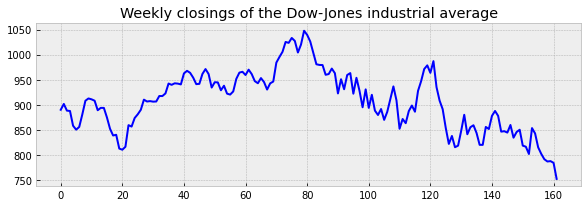

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Preprocessing

In [6]:
n_predict = 15
train = dowjones_closing["Close"][:len(dowjones_closing["Close"])-n_predict]
test = dowjones_closing["Close"][len(dowjones_closing["Close"])-n_predict:]


# Prediction EMA

In [7]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

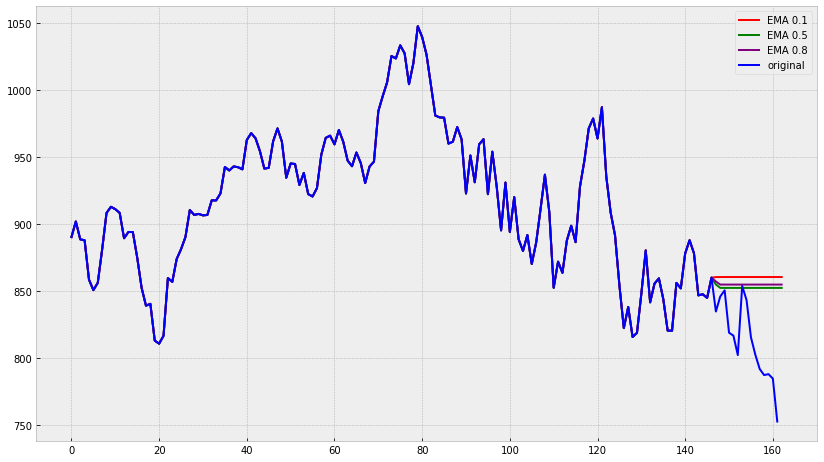

In [8]:
alphas = [0.1,0.5,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(train, alphas[i], len(test))
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(dowjones_closing["Close"], color='blue',label='original')
    plt.legend()

# Score

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
mean_squared_error(ser[-len(test):], test)

2585.3956184663684

# Стационарный ряд
Возьмем из прошлого домашнеого задания

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def test_stationarity(timeseries):
    """Test Dickey-Fuller"""
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return float(dfoutput['p-value'])

## Изменение дисперсии

In [13]:
from scipy.stats import boxcox

In [14]:
for cnt, (k, v) in enumerate(all_series.items()):
    print(f'---- Time Series №{cnt+1}----')
    all_series[k] = boxcox(all_series[k], 0)
    if test_stationarity(all_series[k]) < 0.01:
        print(f'Ряд \'{k}\' стационарный')
    else:
        print(f'Ряд \'{k}\' нестационарный')

---- Time Series №1----
Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64
Ряд 'Weekly closings of the Dow-Jones industrial average' нестационарный


## Дифференцирование (убирание тренда)

In [15]:
for cnt, (k, v) in enumerate(all_series.items()):
    print(f'---- Time Series №{cnt+1}----')
    all_series[k] = np.diff(all_series[k], 1)
    if test_stationarity(all_series[k]) < 0.01:
        print(f'Ряд \'{k}\' стационарный')
    else:
        print(f'Ряд \'{k}\' нестационарный')

---- Time Series №1----
Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64
Ряд 'Weekly closings of the Dow-Jones industrial average' стационарный


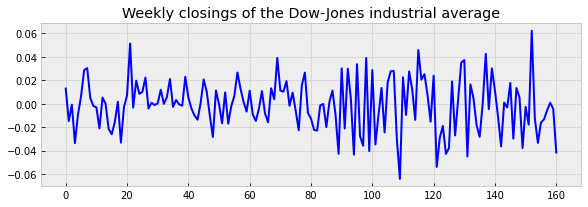

In [16]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        pd.Series(all_series[key]).plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Preprocessing

In [17]:
n_predict = 15
train = pd.Series(all_series["Weekly closings of the Dow-Jones industrial average"][:len(all_series["Weekly closings of the Dow-Jones industrial average"])-n_predict])
test = pd.Series(all_series["Weekly closings of the Dow-Jones industrial average"][len(all_series["Weekly closings of the Dow-Jones industrial average"])-n_predict:])


# Prediction EMA

In [18]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

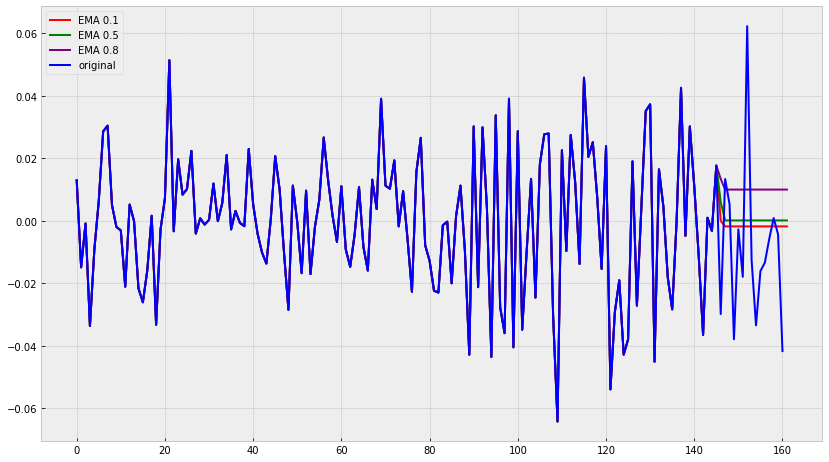

In [19]:
alphas = [0.1,0.5,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(train, alphas[i], len(test))
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(all_series["Weekly closings of the Dow-Jones industrial average"], color='blue',label='original')
    plt.legend()

# Score

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
mean_squared_error(ser[-len(test):], test)

0.0009606808703403158

# Conclusions

Предсказательная способность графиков MA слабая, поэтому принципиальной разницы что использовать в домашнем задании не вижу. Для анализа в работе мною выбран недельный график ДоуДжонса. На сколько мне известно, графики фондового рынка часто анализируют с помощью EMA, его я и применил в работе.

После применения преобразований, приводящих изначальный ряд к стационарному виду, можно заметить, что средне-квадратическая ошибка значительно уменьшилась.

Полагаю, это связано с тем, что из графика исключена основная смысловая составляющая и остался один, близкий к константному, шум с небольшой дисперсией. А предсказания EMA, буквально через пару значений представляют из себя константу, что и приводит к низкому значению ошибки предсказания. Не думаю, что этот прогноз можно считать релевантным.